In [1]:
#dark mode but keep toolbar
!pip install -qqq --user jupyterthemes
import jupyterthemes as jt
x=jt.stylefx.set_nb_theme('oceans16')
x.data=x.data.replace("div#maintoolbar","div#maintoolbar{display: block !important;}.nonexistent:not(existent)")
x

In [2]:
from bs4 import BeautifulSoup, SoupStrainer
import urllib.request
from datetime import date
from dateutil.parser import parse
import pandas as pd
from itertools import permutations
from tqdm import tqdm, trange
from tqdm.contrib import itertools as tqdmitertools
import numpy as np
from scipy.special import logsumexp
# import warnings
# warnings.filterwarnings('ignore')
import networkx as nx
import matplotlib.pyplot as plt
import queue
from IPython import display

In [3]:
def get_UFC_Event_URLs(page=1,verbose=False,pbar=tqdm(total=28,desc="Getting pages")):
    if pbar.total<page:
        pbar.total=page
        pbar.refresh()
    html = urllib.request.urlopen('http://ufcstats.com/statistics/events/completed?page={}'.format(page)).read()
    if verbose:
        print('http://ufcstats.com/statistics/events/completed?page={}'.format(page))
    rows = BeautifulSoup(html,'html.parser', parse_only=SoupStrainer(class_="b-statistics__table-row"))
    urls=[]
    for row in rows:
##        print(row)
        dates = row.find_all(class_="b-statistics__date")
        if len(dates)>0:
            d=parse(dates[0].string.strip()).date()
            if d<date.today():
                a=row.find_all("a")
##                print(a)
                for url in a:
##                    print(url)
                    if url.has_attr("href"):
                        urls.append([d,url['href']])
    if verbose:
        print("Page {} completed".format(page))
    pbar.update(1)
    if len(urls)>0:
        nextUrls = get_UFC_Event_URLs(page=page+1,verbose=verbose,pbar=pbar)
        urls.extend(nextUrls)
    else:
        pbar.total=page
        pbar.refresh()
    pbar.close()
    return urls
def get_Fight_results(url):
    html = urllib.request.urlopen(url).read()
    rows = BeautifulSoup(html,'html.parser',parse_only=SoupStrainer("tr"))
    fights = []
    for row in rows:
        cols = row.find_all("td")
        if len(cols)<2: continue
        w = len(cols[0].find_all("p"))==1
        f = [p.text.strip() for p in cols[1].find_all("p")]
##        print(f[0],"beat" if w else "drew",f[1])
        fights.append([f,int(w)])
    return fights
dfs=[]
i=0
urls=sorted(get_UFC_Event_URLs())
print("{} fights found".format(len(urls)))
events = {}
dates=[]
for fight in tqdm(urls,desc="Reading pages"):
    d,url = fight
#     print(d)
#     if d<parse("2024-08-10").date():
#         break
    dates.append(d)
    fights = get_Fight_results(url)
    for f in fights:
        a,b,w = f[0][0],f[0][1],f[1]
        if a>b:
            a,b,w=b,a,-w
        name = a+" VS "+b
        if name in events:
            events[name]+=1
        else:
            events[name]=1
        name+=" "+str(events[name])
        dfs.append(pd.DataFrame({"Name":[name],"Date":[d],"Fighter_1":[a],"Fighter_2":[b],"Decision":[w]},index=([i])))
        i+=1
df = pd.concat(dfs)
print(df.shape)
print(df.head(10))

Getting pages: 100%|███████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.92it/s]


726 fights found


Reading pages: 100%|█████████████████████████████████████████████████████████████████| 726/726 [05:50<00:00,  2.07it/s]


(8102, 5)
                               Name        Date       Fighter_1  \
0  Gerard Gordeau VS Royce Gracie 1  1993-11-12  Gerard Gordeau   
1  Jason DeLucia VS Trent Jenkins 1  1993-11-12   Jason DeLucia   
2    Ken Shamrock VS Royce Gracie 1  1993-11-12    Ken Shamrock   
3  Gerard Gordeau VS Kevin Rosier 1  1993-11-12  Gerard Gordeau   
4   Ken Shamrock VS Patrick Smith 1  1993-11-12    Ken Shamrock   
5   Art Jimmerson VS Royce Gracie 1  1993-11-12   Art Jimmerson   
6    Kevin Rosier VS Zane Frazier 1  1993-11-12    Kevin Rosier   
7    Gerard Gordeau VS Teila Tuli 1  1993-11-12  Gerard Gordeau   
8   Patrick Smith VS Royce Gracie 1  1994-03-11   Patrick Smith   
9   Remco Pardoel VS Royce Gracie 1  1994-03-11   Remco Pardoel   

       Fighter_2  Decision  
0   Royce Gracie        -1  
1  Trent Jenkins         1  
2   Royce Gracie        -1  
3   Kevin Rosier         1  
4  Patrick Smith         1  
5   Royce Gracie        -1  
6   Zane Frazier         1  
7     Teila Tuli    

In [4]:
class HMM:
    def __init__(self,N=20):
        self.N=N
        self.A=np.ones((N,N))/N
        L=np.array([[1/(1.1+10**((j-i)/N)) for j in range(N)] for i in range(N)])
        self.B=np.array([L,1-L-L.T,L.T])
        self.PE=0
#         self.gamma=np.ones((T,f,N))/N
    def setUpBatches(self,df,dates,batchSize=30):
        self.T=len(dates)
        self.fighters = set(df['Fighter_1'].unique())
        self.fighters.update(set(df['Fighter_2'].unique()))
        self.findex = {}
        self.F=len(self.fighters)
        self.dates=dates
        f=0
        for i in self.fighters:
            self.findex[i]=f
            f+=1
        batches=self.T//batchSize
        self.bfindex=[[] for i in range(batches)]
        fights=[[] for i in range(batches)]
        for ind, row in df.iterrows():
            f1=self.findex[row['Fighter_1']]
            f2=self.findex[row['Fighter_2']]
            t=dates.index(row['Date'])
            d=row['Decision']
            b=min(t//batchSize,batches-1)
            if f1 not in self.bfindex[b]:
                self.bfindex[b].append(f1)
                f1=len(self.bfindex[b])-1
            else:
                f1=self.bfindex[b].index(f1)
            if f2 not in self.bfindex[b]:
                self.bfindex[b].append(f2)
                f2=len(self.bfindex[b])-1
            else:
                f2=self.bfindex[b].index(f2)
            fights[b].append([t-b*batchSize,f1,f2,d])
        self.Ys=[]
        self.batches=[b*batchSize for b in range(batches)]+[self.T]
        for b in range(batches):
            Y=np.full((self.batches[b+1]-self.batches[b],len(self.bfindex[b]),2),-1)
            for i in fights[b]:
                Y[i[0],i[1],0]=i[2]
                Y[i[0],i[1],1]=1+i[3]
                Y[i[0],i[2],0]=i[1]
                Y[i[0],i[2],1]=1-i[3]
            self.Ys.append(Y)
        self.alphas=np.ones((self.T,self.F,self.N))
        self.betas=np.ones((self.T,self.F,self.N))
        self.gammas=np.ones((self.T,self.F,self.N))/self.N
        self.epsilons=np.ones((self.T-1,self.F,self.N,self.N))
    def Train(self,batch,minits=10,maxits=500,convergence=-8.3):
        PE=0.5
        PEs,dAs,dBs,dPIs=[0.5],[0],[0],[0]
        PI=self.gammas[self.batches[batch],self.bfindex[batch]]
        best=[-1,self.A,self.B,PI,PE]
        oldA,oldB,oldPI=self.A,self.B,PI
        pbar=tqdm(total=maxits,desc='batch {}'.format(batch))
        fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2)
        ax1.set_title("Performance Evalutation")
        ax2.set_title("Delta A")
        ax3.set_title("Delta B")
        ax4.set_title("Delta PI")
        for i in range(maxits):
            try:
                PE=self.Update(batch, display=False, iteration=i, use_stored_values=False)
        #         alpha=np.empty(0)
                PI=self.gammas[self.batches[batch],self.bfindex[batch]]
                if np.isnan(PE):
                    print('crashed')
                    break
                if PE>1:
                    print('incorrect calculation')
                    print('A:\n{}\nB:\n{}\nPI:\n{}\nPE:\n{}'.format(self.A,self.B,PI,PE))
                    pbar.total=i
                    pbar.refresh()
                    break
            #     print(PEp)
                if PE>best[-1]:
                    best=[i,self.A,self.B,PI,PE]
            #     print(PEp)
                dA=np.linalg.norm(np.abs(self.A.flatten()-oldA.flatten())/oldA.flatten())/(self.N*self.N)
                dB=np.linalg.norm(np.abs(self.B.flatten()-oldB.flatten())/oldB.flatten())/(self.N*self.N*3)
                dPI=np.linalg.norm(np.abs(PI.flatten()-oldPI.flatten())/oldPI.flatten())/(len(self.bfindex[batch])*self.N)
                M=20 if convergence>-20 else -int(convergence)+1
                dA,dB,dPI=max([min([np.log(dA),M]),-M]),max([min(np.log(dB),M),-M]),max([min(np.log(dPI),M),-M])
                dAs.append(dA)
                dBs.append(dB)
                dPIs.append(dPI)
                PEs.append(PE)
                if i>=minits and max(dA,dB,dPI)<convergence:
                    print('converged')
                    pbar.total=i
                    pbar.refresh()
                    break
                pbar.update(1)
                ax1.plot(range(len(PEs)),PEs,color='green')
                ax2.plot(range(len(dAs)),dAs,color='red')
                ax3.plot(range(len(dBs)),dBs,color='blue')
                ax4.plot(range(len(dPIs)),dPIs,color='black')
                fig.tight_layout()
                display.display(fig)
                display.clear_output(wait=True)
                oldA,oldB,oldPI=self.A,self.B,PI
            except KeyboardInterrupt:
                break
        print(best)
    def Update(self,batch, display=False, iteration=None, use_stored_values=False):
        N = self.N
        Y = self.Ys[batch]
        T = self.batches[batch+1]-self.batches[batch]
        F = len(self.bfindex[batch])
        # Convert all parameters to log-space
        log_A = np.log(self.A)
        log_B = np.log(self.B)
        log_PI = np.log(self.gammas[self.batches[batch],self.bfindex[batch]])

        # Initialize
        convergence=0.1
        iterations=5

        # Extract f2 and y values
        f2s = np.array([[pair[0] for pair in row] for row in Y])
        ys = np.array([[pair[1] for pair in row] for row in Y])
        valid_f2s = f2s != -1

        # Forward pass (log_alpha)
        if not use_stored_values:
            log_alpha = np.zeros((T, F, N))
            log_beta = np.zeros((T, F, N))
            log_gamma = np.zeros((T, F, N))
            log_epsilon = np.zeros((T - 1, F, N, N))
            for t in tqdm(range(T), leave=False, disable=not display,
                          desc='forward pass | iteration {}'.format(iteration), miniters=1):
                log_alpha[t] = np.minimum(log_PI if t==0 else logsumexp(
                    log_alpha[t-1,:,:,None]+log_A[None,:,:],axis=-2
                ),0)
                temp_alphas=log_alpha[t].copy()
                prev_alpha=log_alpha[t].copy()
                log_alpha[t, valid_f2s[t]] = np.minimum(temp_alphas[valid_f2s[t]]+logsumexp(
                    log_B[ys[t][valid_f2s[t]],:,:]+ log_alpha[t,f2s[t][valid_f2s[t]],None,:],axis=-1
                )-logsumexp(
                    log_alpha[t],axis=-1,keepdims=True
                )[valid_f2s[t]],0)
                its=1
                while abs(np.sum((np.exp(log_alpha[t])-np.exp(prev_alpha))**2))>convergence and its<iterations:
                    prev_alpha=log_alpha[t].copy()
                    log_alpha[t, valid_f2s[t]] = np.minimum(temp_alphas[valid_f2s[t]]+logsumexp(
                        log_B[ys[t][valid_f2s[t]],:,:]+ log_alpha[t,f2s[t][valid_f2s[t]],None,:],axis=-1
                        )-logsumexp(log_alpha[t],axis=-1,keepdims=True)[valid_f2s[t]],0)
                    its+=1
    #         log_alpha[t]+=(logsumexp(log_alpha[t])/F-logsumexp(log_alpha[t],axis=-1))[:,None]/N
        # Backward pass (log_beta)
            log_gamma[T - 1] = -np.log(N)

            for t in tqdm(range(T - 2, -1, -1), leave=False, disable=not display,
                          desc='backward pass | iteration {}'.format(iteration), miniters=1):
                log_beta[t] = logsumexp(
                    log_beta[t + 1,:,None,:] + log_A[None,:,:],axis=-1
                )
                log_beta[t,valid_f2s[t+1]] = logsumexp(
                    log_beta[t + 1,valid_f2s[t+1],None,:,None] + log_A[None,:,:,None]
                    +log_B[ys[t+1][valid_f2s[t+1]],None,:,:]+log_gamma[t+1,f2s[t+1][valid_f2s[t+1]],None,None,:]
                    ,axis=(-2,-1)
                )
                log_gamma[t]=log_alpha[t]+log_beta[t]
                log_gamma[t]-=logsumexp(log_gamma[t],axis=-1,keepdims=True)
                log_epsilon[t]=log_alpha[t,:,:,None]+log_A[None,:,:]+log_beta[t+1,:,None,:]
                log_epsilon[t,valid_f2s[t+1]]+=logsumexp(
                    log_B[ys[t+1][valid_f2s[t+1]],None,:,:]
                    +log_gamma[t+1,f2s[t+1][valid_f2s[t+1]],None,None,:],axis=-1
                )
                log_epsilon[t]-=logsumexp(log_epsilon[t],axis=(-2,-1),keepdims=True)
        else:
            log_alpha=np.log(self.alphas[self.batches[batch]:self.batches[batch+1],self.bfindex[batch]])
            log_beta=np.log(self.betas[self.batches[batch]:self.batches[batch+1],self.bfindex[batch]])
            log_gamma=np.log(self.gammas[self.batches[batch]:self.batches[batch+1],self.bfindex[batch]])
            log_epsilon=np.log(self.epsilons[self.batches[batch]:self.batches[batch+1]-1,self.bfindex[batch]])
    #     Parameter updates
    #     print('Alpha:\n{}\nBeta:\n{}\nGamma\n{}\nEpsilon\n{}'.format(np.exp(log_alpha),np.exp(log_beta),np.exp(log_gamma),np.exp(log_epsilon)))
        log_PIp=log_gamma[0]
        log_PIp-=logsumexp(log_PIp,axis=-1,keepdims=True)
        log_Ap=logsumexp(log_epsilon,axis=(0,1))-logsumexp(log_gamma[:-1],axis=(0,1))[:,None]
        log_Ap-=logsumexp(log_Ap,axis=-1,keepdims=True)
        log_Bp=np.zeros((3,N,N))
        for y in range(3):
            ot,of1,of2=np.ogrid[:T,:F,:F]
        #     print(np.nonzero(Y[ot,of1]==(of2,oy)))
            It,If1,If2=np.nonzero(np.logical_and(Y[ot,of1,0]==of2, Y[ot,of1,1]==y))
        #     I[np.arange(T)[:,None],np.arange(F)[None,:].repeat(T,0)[valid_f2s],f2s[valid_f2s],ys[valid_f2s]]=1
        #     print("I\n",I)
        #     print((log_gamma[It,If1,None,:,None]+log_gamma[It,None,If2,None,:]).shape)
            log_Bp[y]=logsumexp(
                log_gamma[It,If1,None,:,None]+log_gamma[It,None,If2,None,:]
                ,axis=0
            )
        log_Bp-=logsumexp(log_Bp,axis=0,keepdims=True)
        # Forward pass (log_alpha)
        log_alpha = np.zeros((T, F, N))
        log_beta = np.zeros((T, F, N))
        log_gamma = np.zeros((T, F, N))
        log_epsilon = np.zeros((T - 1, F, N, N))
        for t in tqdm(range(T), leave=False, disable=not display,
                      desc='final forward pass | iteration {}'.format(iteration), miniters=1):
            log_alpha[t] = np.minimum(log_PI if t==0 else logsumexp(
                log_alpha[t-1,:,:,None]+log_Ap[None,:,:],axis=-2
            ),0)
            temp_alphas=log_alpha[t].copy()
            prev_alpha=log_alpha[t].copy()
            log_alpha[t, valid_f2s[t]] = np.minimum(temp_alphas[valid_f2s[t]]+logsumexp(
                log_Bp[ys[t][valid_f2s[t]],:,:]+ log_alpha[t,f2s[t][valid_f2s[t]],None,:],axis=-1
            )-logsumexp(
                log_alpha[t],axis=-1,keepdims=True
            )[valid_f2s[t]],0)
            its=1
            while abs(np.sum((np.exp(log_alpha[t])-np.exp(prev_alpha))**2))>convergence and its<iterations:
                prev_alpha=log_alpha[t].copy()
                log_alpha[t, valid_f2s[t]] = np.minimum(temp_alphas[valid_f2s[t]]+logsumexp(
                    log_Bp[ys[t][valid_f2s[t]],:,:]+ log_alpha[t,f2s[t][valid_f2s[t]],None,:],axis=-1
                    )-logsumexp(
                    log_alpha[t],axis=-1,keepdims=True
                    )[valid_f2s[t]],0)
                its+=1
        #Backward Pass
        log_gamma[T - 1] = -np.log(N)

        for t in tqdm(range(T - 2, -1, -1), leave=False, disable=not display,
                      desc='final backward pass | iteration {}'.format(iteration), miniters=1):
            log_beta[t] = logsumexp(
                log_beta[t + 1,:,None,:] + log_Ap[None,:,:],axis=-1
            )
            log_beta[t,valid_f2s[t+1]] = logsumexp(
                log_beta[t + 1,valid_f2s[t+1],None,:,None] + log_Ap[None,:,:,None]
                +log_Bp[ys[t+1][valid_f2s[t+1]],None,:,:]+log_gamma[t+1,f2s[t+1][valid_f2s[t+1]],None,None,:]
                ,axis=(-2,-1)
            )
            log_gamma[t]=log_alpha[t]+log_beta[t]
            log_gamma[t]-=logsumexp(log_gamma[t],axis=-1,keepdims=True)
            log_epsilon[t]=log_alpha[t,:,:,None]+log_Ap[None,:,:]+log_beta[t+1,:,None,:]
            log_epsilon[t,valid_f2s[t+1]]+=logsumexp(
                log_Bp[ys[t+1][valid_f2s[t+1]],None,:,:]
                +log_gamma[t+1,f2s[t+1][valid_f2s[t+1]],None,None,:],axis=-1
            )
            log_epsilon[t]-=logsumexp(log_epsilon[t],axis=(-2,-1),keepdims=True)
        ot,of1,of2,oy=np.ogrid[:T,:F,:F,:3]
    #     print(np.nonzero(Y[ot,of1]==(of2,oy)))
        It,If1,If2,Iy=np.nonzero(np.logical_and(Y[ot,of1,0]==of2, Y[ot,of1,1]==oy))
    #     I[np.arange(T)[:,None],np.arange(F)[None,:].repeat(T,0)[valid_f2s],f2s[valid_f2s],ys[valid_f2s]]=1
    #     print("I\n",I)
    #     print((log_gamma[It,If1,None,:,None]+log_gamma[It,None,If2,None,:]).shape)
        PE=logsumexp(log_gamma[It,If1,:,None]+log_gamma[It,If2,None,:]+log_Bp[Iy,:,:],axis=(1,2))
#         print(np.exp(PE))
        PE=np.sum(np.exp(PE))/PE.shape[0]
    #         log_alpha[t]+=(logsumexp(log_alpha[t])/F-logsumexp(log_alpha[t],axis=-1))[:,None]/N
        self.A=np.exp(log_Ap)
        self.B=np.exp(log_Bp)
        self.alphas[self.batches[batch]:self.batches[batch+1],self.bfindex[batch]]=np.exp(log_alpha)
        self.betas[self.batches[batch]:self.batches[batch+1],self.bfindex[batch]]=np.exp(log_beta)
        self.gammas[self.batches[batch]:self.batches[batch+1],self.bfindex[batch]]=np.exp(log_gamma)
        self.epsilons[self.batches[batch]:self.batches[batch+1]-1,self.bfindex[batch]]=np.exp(log_epsilon)
        return(PE)
#     print('alpha: ',np.exp(log_alpha))
#     print('beta: ',np.exp(log_beta))
#     print('gamma: ',np.exp(log_gamma))
#     print('epsilon: ',np.exp(log_epsilon))
#     return [0,0,0,0]
    def estimatedT(self,date):
        return min(range(self.T), key=lambda t:abs(self.dates[t].timestamp() - date.timestamp()))
    def Prediction(self,f1,f2,date):
        t=self.estimatedT(date)
        f1=self.findex[f1]
        f2=self.findex[f2]
        log_gamma_f1=np.log(self.gammas[t,f1])
        log_gamma_f2=np.log(self.gammas[t,f2])
        log_B=np.log(self.B)
        ys=['Loss','Draw','Win']
        log_p=[logsumexp(log_gamma_f1[:,None]+log_gamma_f2[None,:]+log_B[y]) for y in range(3)]
        return {ys[i]:np.exp(log_p[i]) for i in range(3)}

In [21]:
hmm = HMM(50)
hmm.setUpBatches(df,dates,30)
# for i in range(len(hmm.batches)-1):
print(hmm.batches)

[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 726]


batch 23: 100%|████████████████████████████████████████████████████████████████████████| 50/50 [08:12<00:00,  9.85s/it]

[33, array([[0.0207261 , 0.02082863, 0.02076697, ..., 0.01949475, 0.01981949,
        0.02035939],
       [0.02078724, 0.02064256, 0.0204148 , ..., 0.0197784 , 0.01990302,
        0.02003194],
       [0.02061522, 0.02046247, 0.02024655, ..., 0.01991827, 0.02003825,
        0.02018683],
       ...,
       [0.0203709 , 0.02024886, 0.02006458, ..., 0.02009285, 0.0202416 ,
        0.02051299],
       [0.02050867, 0.0203586 , 0.02013816, ..., 0.02002384, 0.02013855,
        0.02033413],
       [0.02091162, 0.02068443, 0.0203543 , ..., 0.01991048, 0.01991705,
        0.01780435]]), array([[[4.95964963e-01, 4.96591782e-01, 4.97497088e-01, ...,
         4.97492695e-01, 4.96719137e-01, 9.41806901e-02],
        [4.95919753e-01, 4.96525762e-01, 4.97401183e-01, ...,
         4.97396775e-01, 4.96648660e-01, 9.31721422e-02],
        [4.95845822e-01, 4.96422141e-01, 4.97254936e-01, ...,
         4.97250506e-01, 4.96538681e-01, 9.15291206e-02],
        ...,
        [4.95850609e-01, 4.96426916e-01, 4.9

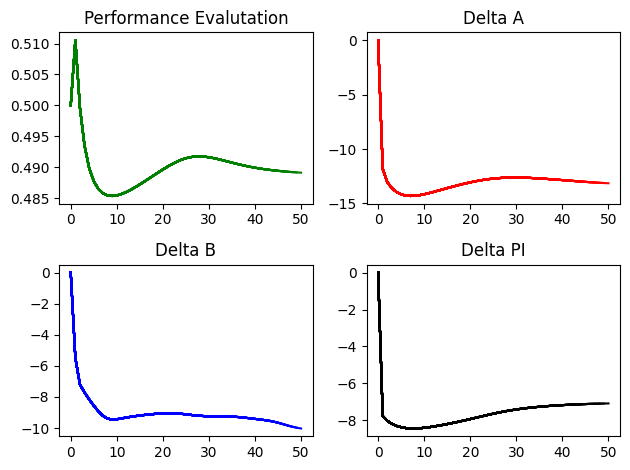

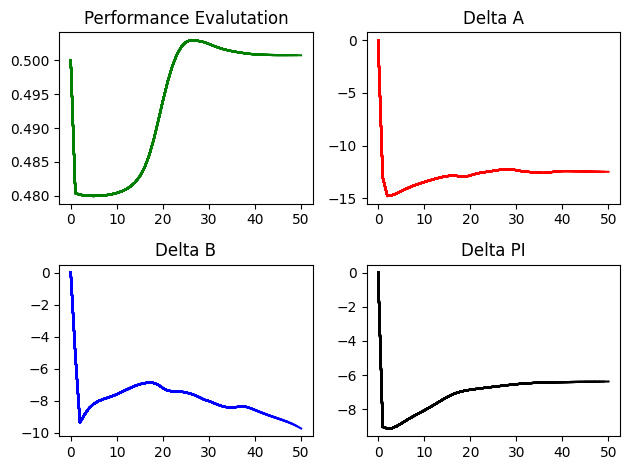

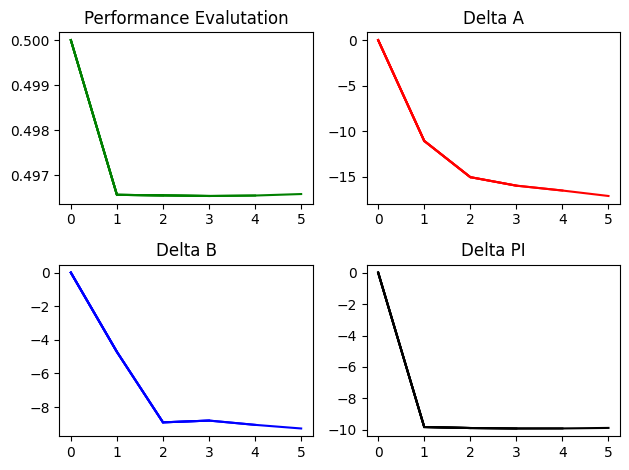

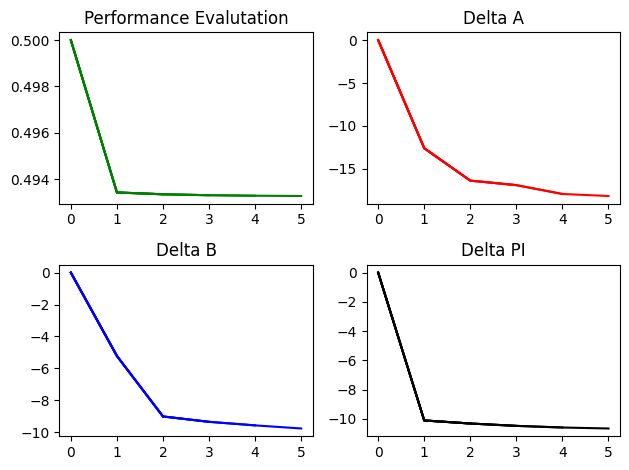

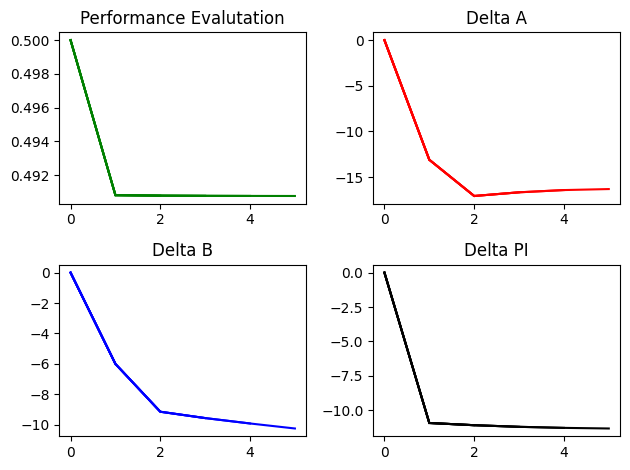

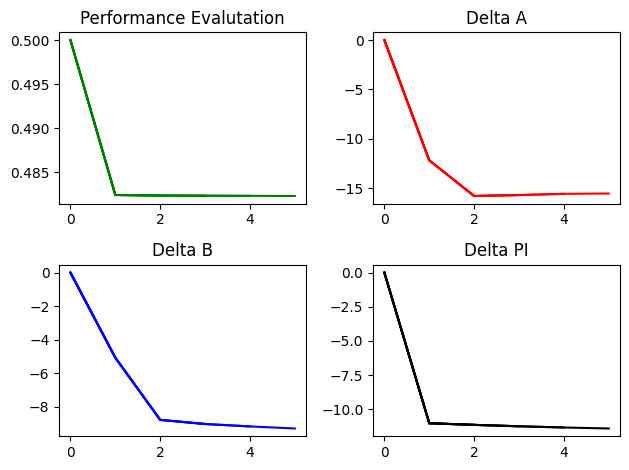

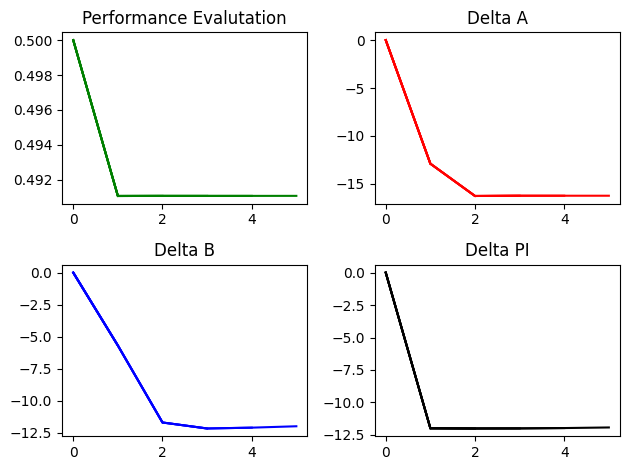

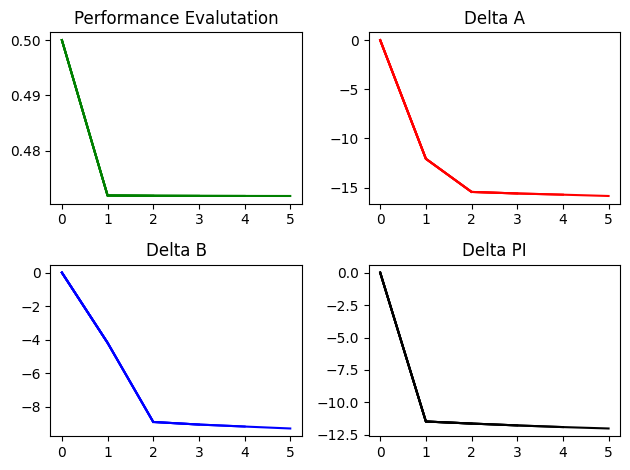

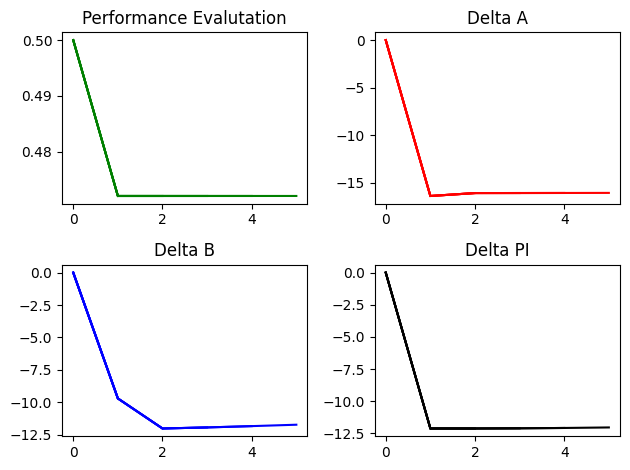

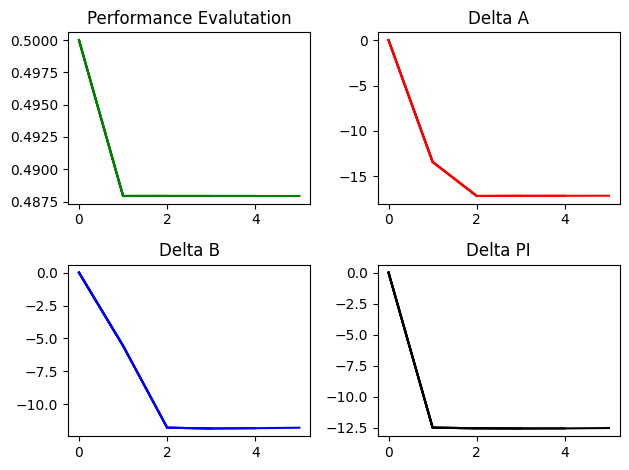

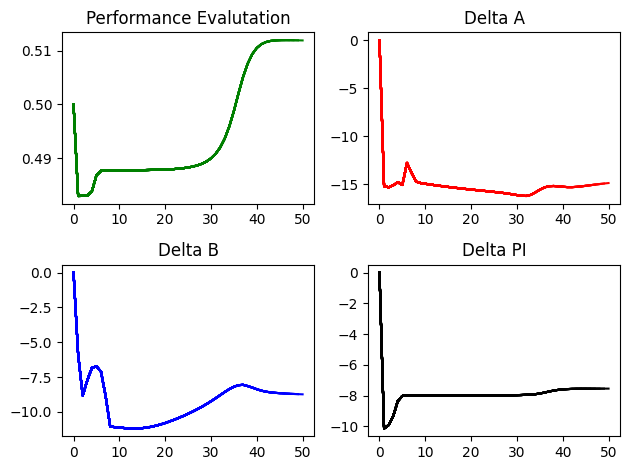

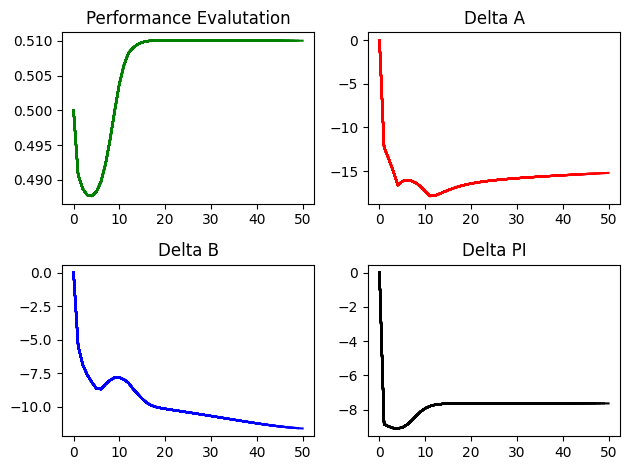

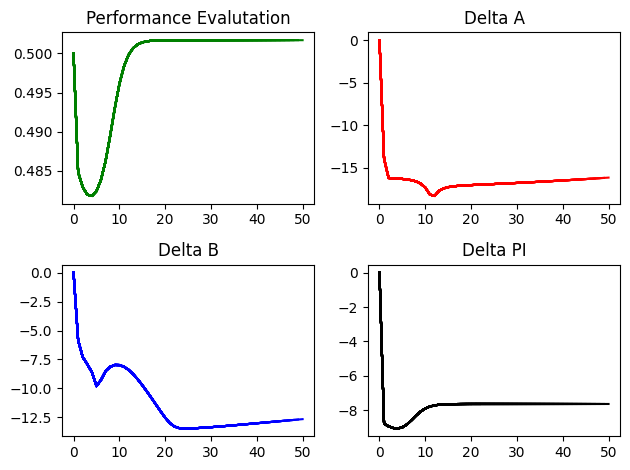

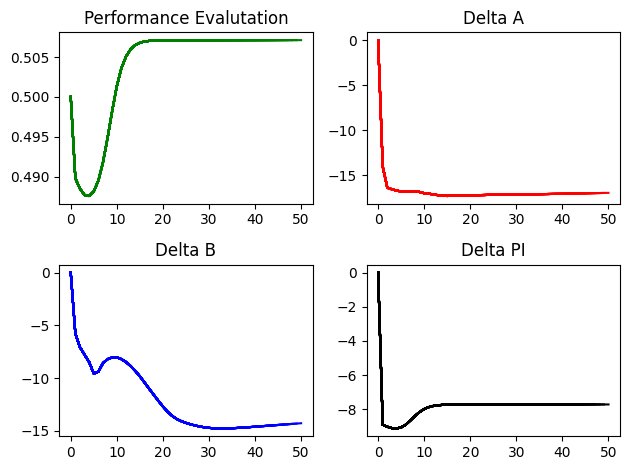

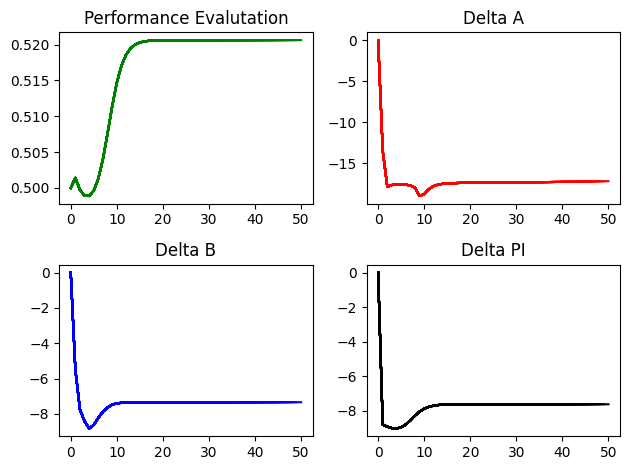

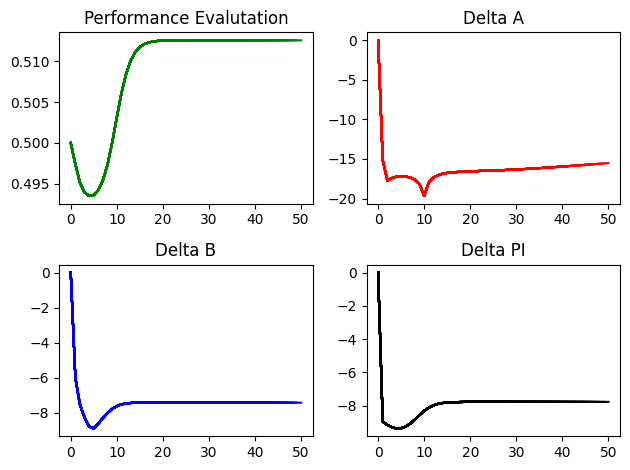

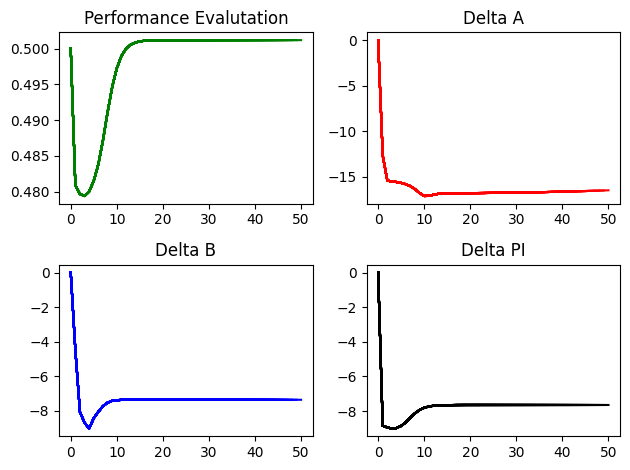

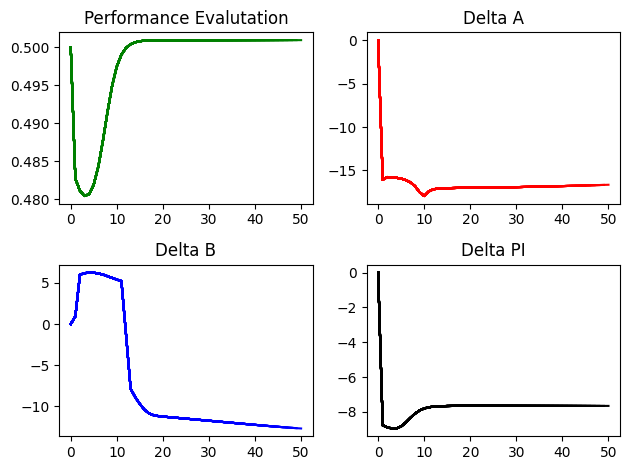

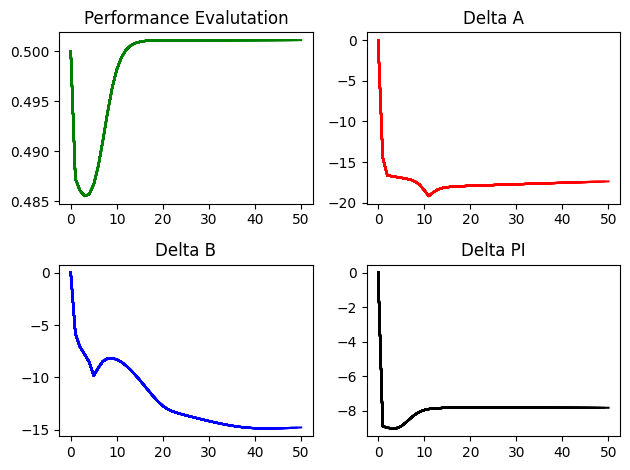

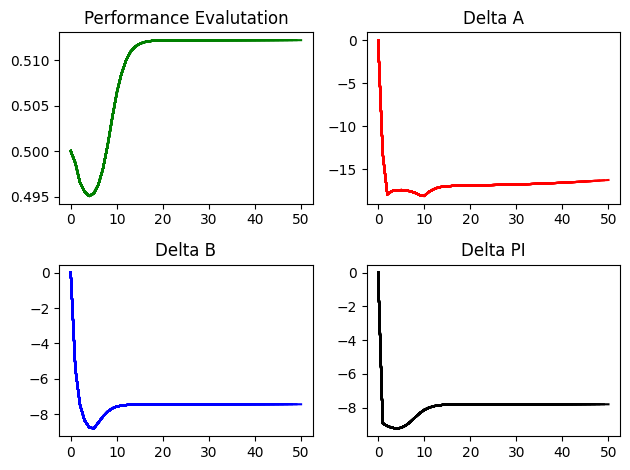

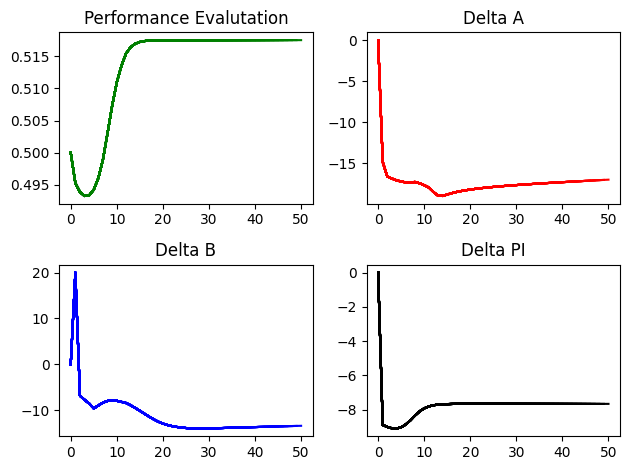

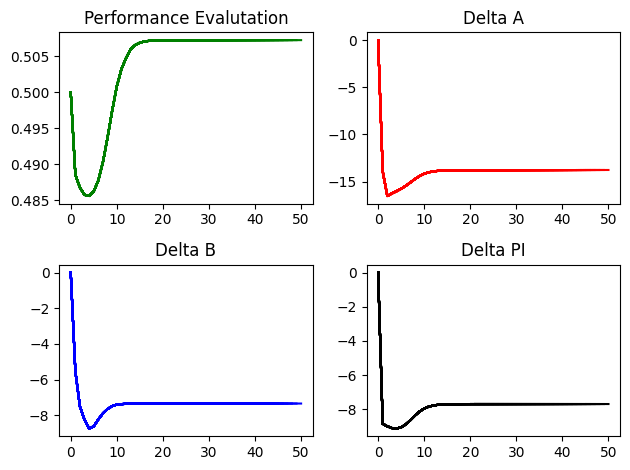

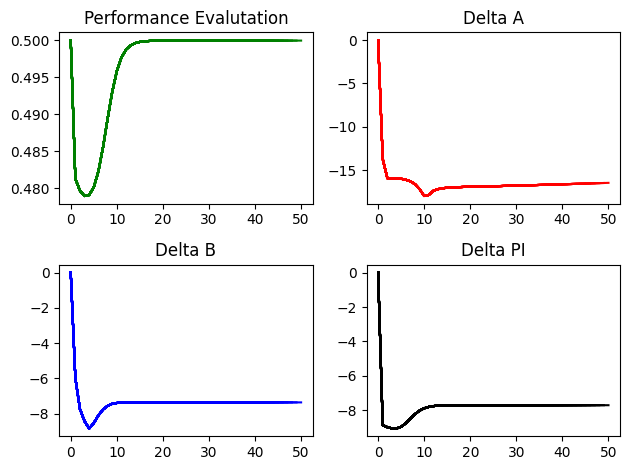

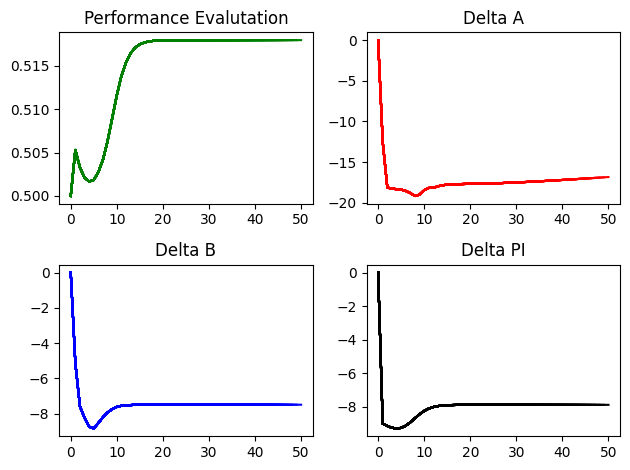

In [22]:
for i in range(len(hmm.batches)-1):
    hmm.Train(i,minits=5,maxits=50,convergence=-9)


batch 23:  90%|████████████████████████████████████████████████████████████▉       | 448/500 [1:25:16<11:47, 13.61s/it]

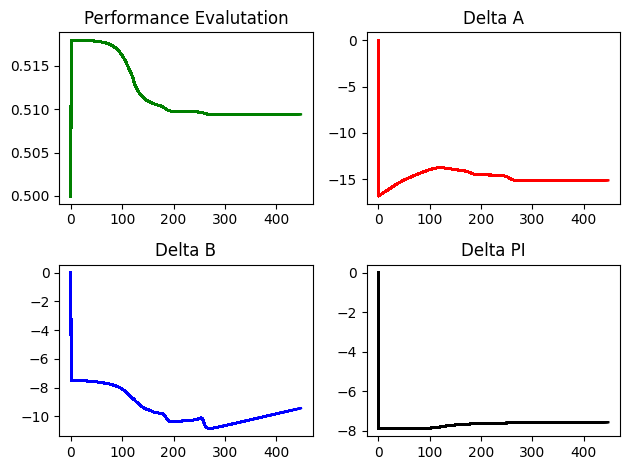

In [ ]:
hmm.Train(23,5,500,-10)

In [ ]:
print(hmm.Prediction("Anshul Jubli","Islam Makhachev",parse("2021-08-10").date()))